In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [31]:
p = ['ya ebal tvoir rotok', 'i am ne nenenen neen ']
filterPair(p)

True

In [32]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    print("initial_pairs_length", len(pairs))
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def filterPair(p):
    try:
        return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH 
#             and p[1].startswith(eng_prefixes)
    except:
#         print(p)
        return False


def filterPairs(pairs):
    pairs_list = []
    except_count = 0
    ok_count = 0
    for pair in pairs:
        filt_result = filterPair(pair)
        if filt_result == False:
            except_count += 1
        else:
            pairs_list.append(pair)
    print(except_count, "pairs_filtered", len(pairs_list), "pairs to be processed")
    return pairs_list

In [33]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
initial_pairs_length 135842
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['vous etes desormais une femme .', 'you re a woman now .']


In [22]:
input_lang.name

'fra'

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# ????

In [8]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [9]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [10]:
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [11]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [12]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [13]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [14]:
import time

In [27]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    print("===========TRAIN_ITERATION_STARTED=================")
    encoder_hidden = encoder.initHidden()
    print("encoder_hidden", encoder_hidden.shape)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    print("input_length_to_be_processed",input_length,"target_length",target_length )

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    print("\n===ENCODING_CYCLE_STARTED====")
    print("encoder_outputs.shape", encoder_outputs.shape)
    for ei in range(input_length):
        print("ei", ei)
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    print("\n===DECODING_CYCLE_STARTED====")
    #use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    use_teacher_forcing = True 
    if use_teacher_forcing:
        print("use_teacher_forcing=True")
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            print("will_send_to_loss", "decoder_output",decoder_output.shape, "target_tensor", target_tensor[di],"decoder_hidden",decoder_hidden.shape)
            loss += criterion(decoder_output, target_tensor[di])
            print("loss",loss)
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        print("==encoding_now==")
        embedded = self.embedding(input).view(1, 1, -1)
        print("embedded_forward", embedded.shape)
        print("hidden_initial", hidden.shape)
        output = embedded
        output, hidden = self.gru(output, hidden)
        print("output_after_gru",output.shape)
        print("hidden_after_gru",hidden.shape)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        print("==decoding_now==")
        print("forward_decoder_now", input)
        embedded_input = self.embedding(input).view(1, 1, -1)
        print("embedded_input = self.embedding(input).view(1, 1, -1)","embedded_input=",  embedded_input.shape)
        embedded_input = self.dropout(embedded_input)
        print("embedded_input = self.dropout(embedded_input)|embedded_input =", embedded_input.shape)
        
        print("---attention_process----")
        concat = torch.cat((embedded_input[0], hidden[0]), 1)
        print("concat =torch.cat((embedded_input[0], hidden[0]), 1)", "concat", concat.shape)
        linear = self.attn(torch.cat((embedded_input[0], hidden[0]), 1))
        print("linear = self.attn(torch.cat((embedded_input[0], hidden[0]), 1))||nn.Linear(self.hidden_size * 2, self.max_length)",linear.shape)
    
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded_input[0], hidden[0]), 1)), dim=1)
        print("attn_weights = F.softmax(self.attn(torch.cat((embedded_input[0], hidden[0]), 1)), dim=1)",attn_weights.shape )
        print("will send encoder_outputs", encoder_outputs.shape)
        print("encoder_outputs.unsqueeze(0)", encoder_outputs.unsqueeze(0).shape)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        print("attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0)) (attn_weights*encoder_outputs)", attn_applied.shape)
        
        output = torch.cat((embedded_input[0], attn_applied[0]), 1)
        print("output = torch.cat((embedded_input[0], attn_applied[0]), 1)", embedded_input[0].shape,attn_applied[0].shape, "output",output.shape  )
        output = self.attn_combine(output).unsqueeze(0)
        print("output = self.attn_combine(output).unsqueeze(0)/ nn.Linear(self.hidden_size * 2, self.hidden_size)","output", output.shape )

        output = F.relu(output)
        print("output = F.relu(output)",output.shape )
        output, hidden = self.gru(output, hidden)
        print("output, hidden = self.gru(output, hidden)", "output",output.shape, "hidden", hidden.shape )
        output = F.log_softmax(self.out(output[0]), dim=1)
        print("output = F.log_softmax(self.out(output[0]), dim=1)||nn.Linear(self.hidden_size, self.output_size)",output.shape )
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [18]:
len(pairs)

10599

In [19]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    #training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    training_pairs = [tensorsFromPair(pairs[i]) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        print("current_pair_is", pairs[iter - 1], training_pair)
        
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        if iter == 1:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            break

    showPlot(plot_losses)

current_pair_is ['j ai ans .', 'i m .'] (tensor([[2],
        [3],
        [4],
        [5],
        [1]]), tensor([[2],
        [3],
        [4],
        [1]]))
===========TRAIN_ITERATION_STARTED=================
encoder_hidden torch.Size([1, 1, 256])
input_length_to_be_processed 5 target_length 4

===ENCODING_CYCLE_STARTED====
encoder_outputs.shape torch.Size([10, 256])
ei 0
==encoding_now==
embedded_forward torch.Size([1, 1, 256])
hidden_initial torch.Size([1, 1, 256])
output_after_gru torch.Size([1, 1, 256])
hidden_after_gru torch.Size([1, 1, 256])
ei 1
==encoding_now==
embedded_forward torch.Size([1, 1, 256])
hidden_initial torch.Size([1, 1, 256])
output_after_gru torch.Size([1, 1, 256])
hidden_after_gru torch.Size([1, 1, 256])
ei 2
==encoding_now==
embedded_forward torch.Size([1, 1, 256])
hidden_initial torch.Size([1, 1, 256])
output_after_gru torch.Size([1, 1, 256])
hidden_after_gru torch.Size([1, 1, 256])
ei 3
==encoding_now==
embedded_forward torch.Size([1, 1, 256])
hidden_ini

<Figure size 432x288 with 0 Axes>

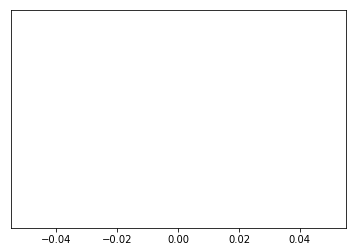

In [28]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
trainIters(encoder1, attn_decoder1, 5, print_every=5000)

In [92]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
output = loss(m(input), target)
output.backward()